# Test YOLO model

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline


In [ ]:
model = YOLO("runs/detect/train/weights/best.pt")

metrics = model.val(data="datasets/yolo_data/data.yaml", workers=0)

print(f"mAP@0.5: {metrics.box.map50:.4f}")      # mAP@0.5
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")   # mAP@0.5:0.95
print(f"Precision: {metrics.box.mp:.4f}")  
print(f"Recall: {metrics.box.mr:.4f}")      

# Additional metrics
print(f"F1-Score: {2 * (metrics.box.mp * metrics.box.mr) / (metrics.box.mp + metrics.box.mr):.4f}")
print(f"Fitness: {metrics.fitness:.4f}")

Ultralytics 8.3.162  Python-3.10.13 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070 Ti, 8191MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access  (ping: 0.30.2 ms, read: 13.913.6 MB/s, size: 140.6 KB)


val: Scanning E:\AIO2024\OCR\datasets\yolo_data\val\labels.cache... 42 images, 0 backgrounds, 0 corrupt: 100%|██████████| 42/42 [00:00<?, ?it/s]


image 1/1 e:\AIO2024\OCR\datasets\yolo_data\test\images\aPICT0020.JPG: 640x640 3 texts, 41.6ms
Speed: 5.0ms preprocess, 41.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


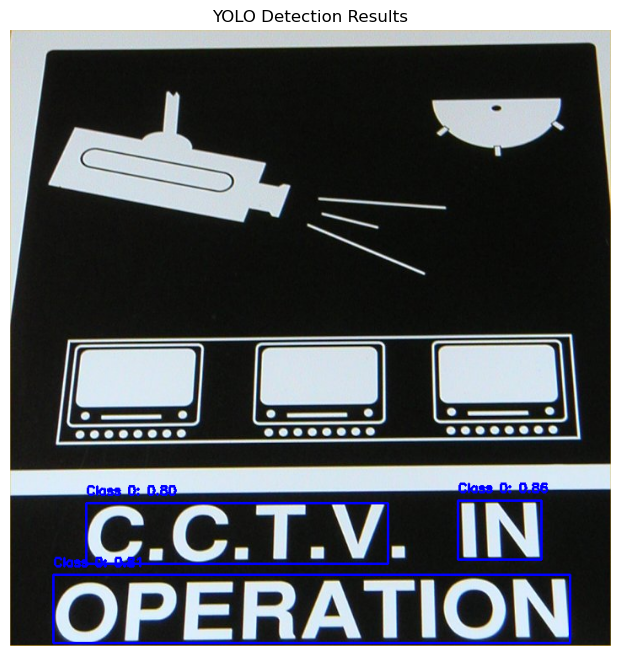

In [ ]:
results = model(f"datasets\\yolo_data\\test\\images\\aPICT0020.JPG")

for result in results:
    boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes
    scores = result.boxes.conf.cpu().numpy()  # Confidence scores
    classes = result.boxes.cls.cpu().numpy()  # Class indices

    for box, score, cls in zip(boxes, scores, classes):
        x1, y1, x2, y2 = map(int, box)
        label = f"Class {int(cls)}: {score:.2f}"
        cv2.rectangle(result.orig_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(result.orig_img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('YOLO Detection Results')
plt.show()

# Test CRNN model